## Assessing Student Learning Outcomes through Study Time and Spaced Repetition

### Introduction

Nariman Avakoli, Kevin Lu

To score well on a test, it's crucial to adopt a method of study that has been historically and scientifically proven to be efficient. The question is, is it better to study for an extended period of time the night before the exam or to distribute study sessions in intervals of 30-40 minutes over a couple of days?

To answer this question, we conducted an extensive data analysis to compare the effectiveness of cramming and distributed studying. Our predictive question of interest was, "What is the level of knowledge that a student has gained from studying, based on their quantity and distribution of study time?"

We obtained a comprehensive dataset from the UCI machine learning repository (Hamdi et al.), which studied the relationship between the knowledge status/level of students and various predictor variables. However, their algorithms using machine learning and neural networks were much more complex than ours and their question was broader. Therefore, we didn't require all of their variables.

We focused solely on the predictor variables related to study time and session distribution, as these variables would help us answer our question. We selected the corresponding variables of STG (a scaled and centralized representation of study time relative to other students) and SCG (a normalized variable that represents the frequency of study sessions for a student). Finally, we analyzed how these two variables correlated with our focus variable, UNS, which represents the knowledge level of the student in their respective subject of interest.

### Methodology and Process

First, we needed to import all of the libraries required for the research of our project:

In [306]:
library(tidyverse)
library(repr)
library(tidymodels)
library(readxl)

options(repr.matrix.max.rows = 6)


Next we set the seed for this notebook to make the results reproducible.

In [293]:
set.seed(1)

Let's download the required dataset from the online repository (as read_excel can't directly take urls), and read the files (train and test data is initially provided separately)

<b>Variable Legend</b>
    
- STG (The degree of study time for goal object materials)

- SCG (The degree of repetition number of user for goal object materials)

- STR (The degree of study time of user for related objects with goal object)

- LPR (The exam performance of user for related objects with goal object)

- PEG (The exam performance of user for goal objects)

- UNS (The knowledge level of user)



In [294]:
URL <- "https://archive.ics.uci.edu/ml/machine-learning-databases/00257/Data_User_Modeling_Dataset_Hamdi%20Tolga%20KAHRAMAN.xls"
download.file(URL, "data/user_knowledge_data")
knowledge_train <- read_excel("data/user_knowledge_data", sheet = "Training_Data", range = cell_cols("A:F"))
head(knowledge_train, 10)

knowledge_test <- read_excel("data/user_knowledge_data", sheet = "Test_Data", range = cell_cols("A:F"))
knowledge_test


STG,SCG,STR,LPR,PEG,UNS
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>
0.00,0.00,0.00,0.00,0.00,very_low
0.08,0.08,0.10,0.24,0.90,High
0.06,0.06,0.05,0.25,0.33,Low
⋮,⋮,⋮,⋮,⋮,⋮
0.15,0.02,0.34,0.40,0.01,very_low
0.20,0.14,0.35,0.72,0.25,Low
0.00,0.00,0.50,0.20,0.85,High


STG,SCG,STR,LPR,PEG,UNS
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>
0.00,0.10,0.50,0.26,0.05,Very Low
0.05,0.05,0.55,0.60,0.14,Low
0.08,0.18,0.63,0.60,0.85,High
⋮,⋮,⋮,⋮,⋮,⋮
0.56,0.60,0.77,0.13,0.32,Low
0.66,0.68,0.81,0.57,0.57,Middle
0.68,0.64,0.79,0.97,0.24,Middle


<b>Table 1</b>

Our data has been tidied and is now divided into a training and testing set.

We have also noted that the UNS variable is currently in character format, but in order to measure a student's knowledge level based on these labels, it is necessary to convert the UNS variable into a factor type. This is necessary because our question requires us to measure the knowledge level, and the factor type allows us to capture this information in a meaningful way.


In [305]:
knowledge_train <- mutate(knowledge_train, UNS = as_factor(UNS))
head(knowledge_train, 10)


# for some reason the data provided had very_low named differently in the training and testing sets, correcting here
knowledge_test <- mutate(knowledge_test, UNS = as_factor(UNS)) %>%
    mutate(UNS = recode(UNS,"Very Low" = "very_low"))

# we also had to reorder the UNS column of the test data to be the same as that in the training data so metrics could be collected
knowledge_test$UNS <- factor(knowledge_test$UNS, levels=c('very_low', 'High', 'Low', 'Middle'))
head(knowledge_test, 10)


STG,SCG,STR,LPR,PEG,UNS
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<fct>
0.00,0.00,0.00,0.00,0.00,very_low
0.08,0.08,0.10,0.24,0.90,High
0.06,0.06,0.05,0.25,0.33,Low
⋮,⋮,⋮,⋮,⋮,⋮
0.15,0.02,0.34,0.40,0.01,very_low
0.20,0.14,0.35,0.72,0.25,Low
0.00,0.00,0.50,0.20,0.85,High


STG,SCG,STR,LPR,PEG,UNS
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<fct>
0.00,0.10,0.50,0.26,0.05,very_low
0.05,0.05,0.55,0.60,0.14,Low
0.08,0.18,0.63,0.60,0.85,High
⋮,⋮,⋮,⋮,⋮,⋮
0.12,0.12,0.75,0.68,0.15,Low
0.20,0.20,0.88,0.77,0.80,High
0.16,0.25,0.01,0.10,0.07,very_low


<b>Table 2</b>

We conducted an investigation of the distribution of our focus variable, knowledge levels, among the people in the training set. To do this, we generated a table displaying the number of observations in each UNS level. If one group is highly overrepresented, it could result in more accurate data for that group but skew the overall results when combined with other groups. The distribution was fairly even for each category except for those in the "very low" score category. Although this imbalance is acceptable since low scores are expected to be uncommon, it is crucial that the other categories are accurately represented.

Additionally, we compared the distribution of our focus variable between the testing and training data to ensure consistency.

In [296]:
know_count1 <- nrow(knowledge_train)
    knowledge_train %>%
    group_by(UNS) %>%
    summarize(count = n(),
    percentage = n() / know_count1 * 100)


know_count2 <- nrow(knowledge_test)
    knowledge_test %>%
    group_by(UNS) %>%
    summarize(count = n(),
    percentage = n() / know_count2 * 100)


`summarise()` ungrouping output (override with `.groups` argument)



UNS,count,percentage
<fct>,<int>,<dbl>
very_low,24,9.302326
High,63,24.418605
Low,83,32.170543
Middle,88,34.108527


`summarise()` ungrouping output (override with `.groups` argument)



UNS,count,percentage
<fct>,<int>,<dbl>
very_low,26,17.93103
High,39,26.89655
Low,46,31.72414
Middle,34,23.44828


Our investigation of the distribution of our focus variable showed that the proportions of knowledge levels between the training and testing data were unequal. To resolve this, we combined the data and re-split it with a proportion of 75% in both sets, while using stratification based on the UNS variable to ensure even distributions of knowledge levels. This was done to avoid any potential problems caused by uneven distribution of the predictor variables, and to obtain a more accurate result.

In [297]:
# Merging the data

knowledge <- rbind(knowledge_train, knowledge_test)

# Re-spliting the data

knowledge_split <- initial_split(knowledge, prop = 0.75, strata = UNS)
knowledge_training <- training(knowledge_split)
knowledge_testing <- testing(knowledge_split)

# Checking the distributions again

knowl_count1 <- nrow(knowledge_training)
    knowledge_training %>%
    group_by(UNS) %>%
    summarize(count = n(),
    percentage = n() / knowl_count1 * 100)

knowl_count2 <- nrow(knowledge_testing)
    knowledge_testing %>%
    group_by(UNS) %>%
    summarize(count = n(),
    percentage = n() / knowl_count2 * 100)


`summarise()` ungrouping output (override with `.groups` argument)



UNS,count,percentage
<fct>,<int>,<dbl>
very_low,38,12.50000
High,77,25.32895
Low,97,31.90789
Middle,92,30.26316


`summarise()` ungrouping output (override with `.groups` argument)



UNS,count,percentage
<fct>,<int>,<dbl>
very_low,12,12.12121
High,25,25.25253
Low,32,32.32323
Middle,30,30.30303


<b>Table 3</b>

Next, we plotted two histograms to visualize the distribution of our predictor variables. This helps us to understand the spread of data and identify any potential outliers or skewness in the distribution. By examining the distribution of our predictor variables, we can ensure that our model will be well-informed and more accurately make predictions about a student's knowledge level based on their study time and session distribution.

`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.

`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.



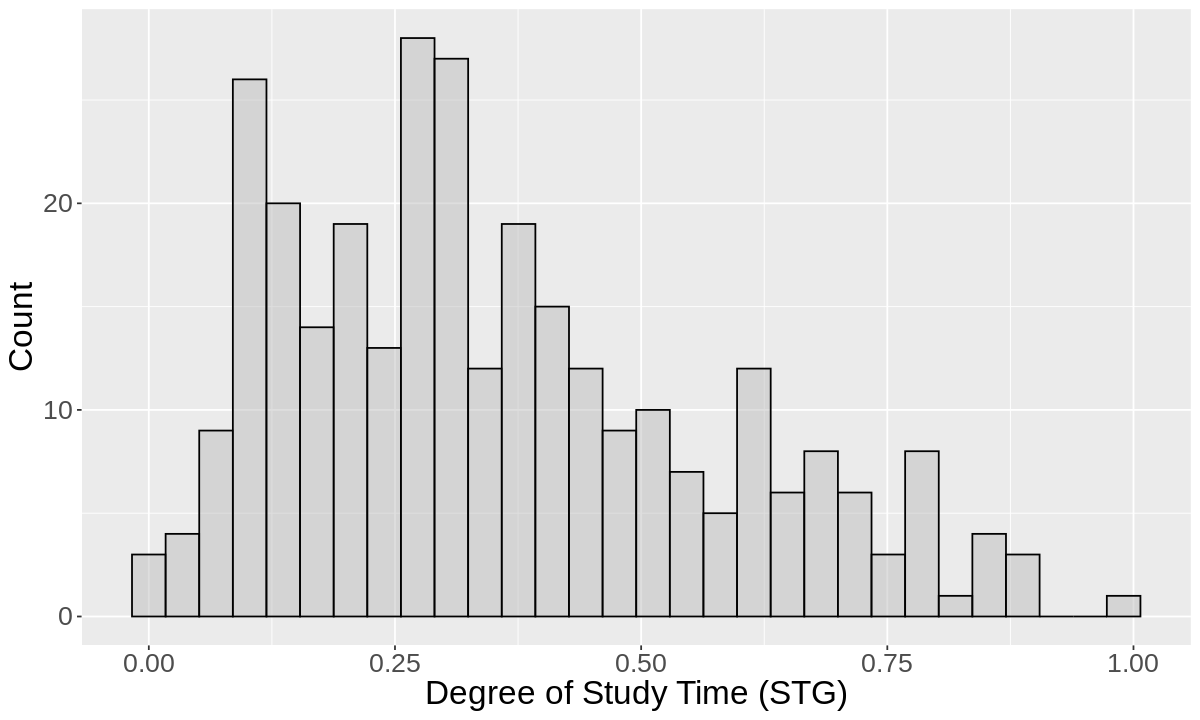

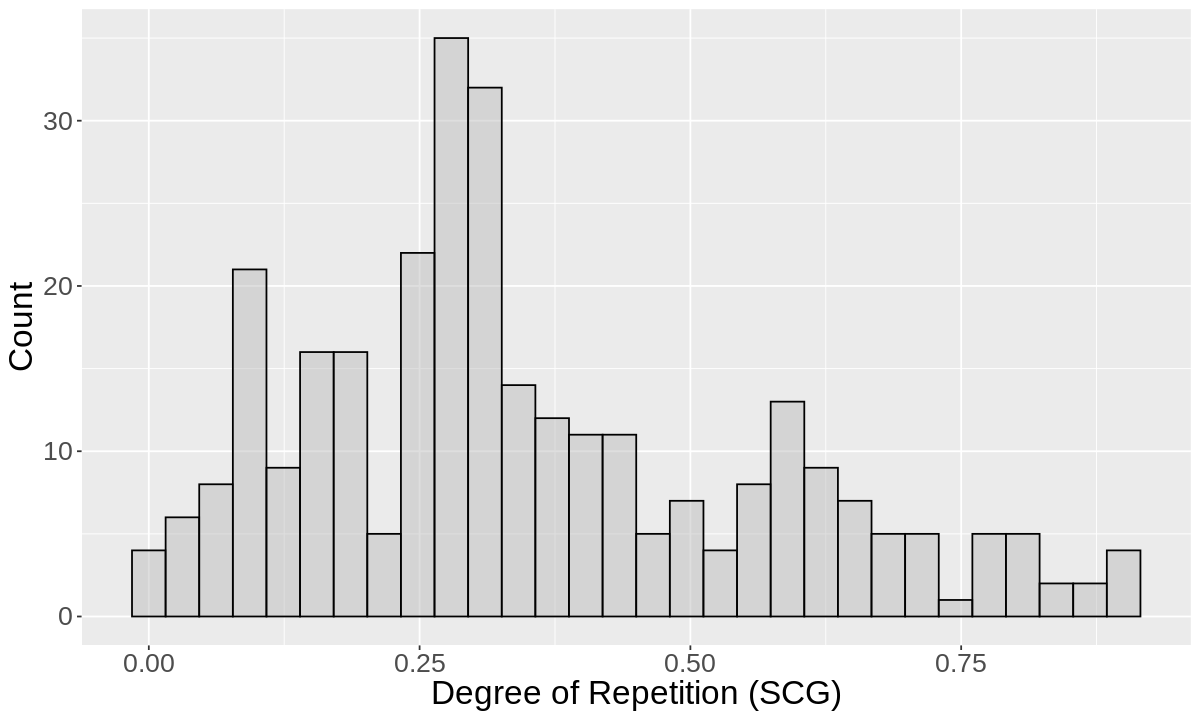

In [298]:
options(repr.plot.width = 10, repr.plot.height = 6)
STG_hist <- ggplot(knowledge_training, aes(x = STG)) +
    geom_histogram(alpha = 0.5, position = "identity", fill = "gray", color = "black") +
    labs(x = "Degree of Study Time (STG)", 
    y = "Count") +
  theme(text = element_text(size = 20))

SCG_hist <- ggplot(knowledge_training, aes(x = SCG)) +
    geom_histogram(alpha = 0.5, position = "identity", fill = "gray", color = "black") +
    labs(x = "Degree of Repetition (SCG)", 
    y = "Count") +
    theme(text = element_text(size = 20))

STG_hist
SCG_hist

<b>Img. 1 A (top) and B (bottom)</b>

After creating histograms to explore the distribution of the predictor variables, we observed that both variables have a concentration of values around the 0.25 zone. However, there were enough values at other distributions that they were not negligible, and the spread was fairly even. As a result, using the entire range of values from the data frame for future steps was deemed acceptable.

Next, we created a scatterplot to gain a general understanding of the relationship between the SCG and STG variables and the student's knowledge level. This visualization allowed us to observe any potential patterns, to inform the direction of our modeling efforts in answering our predictive question.

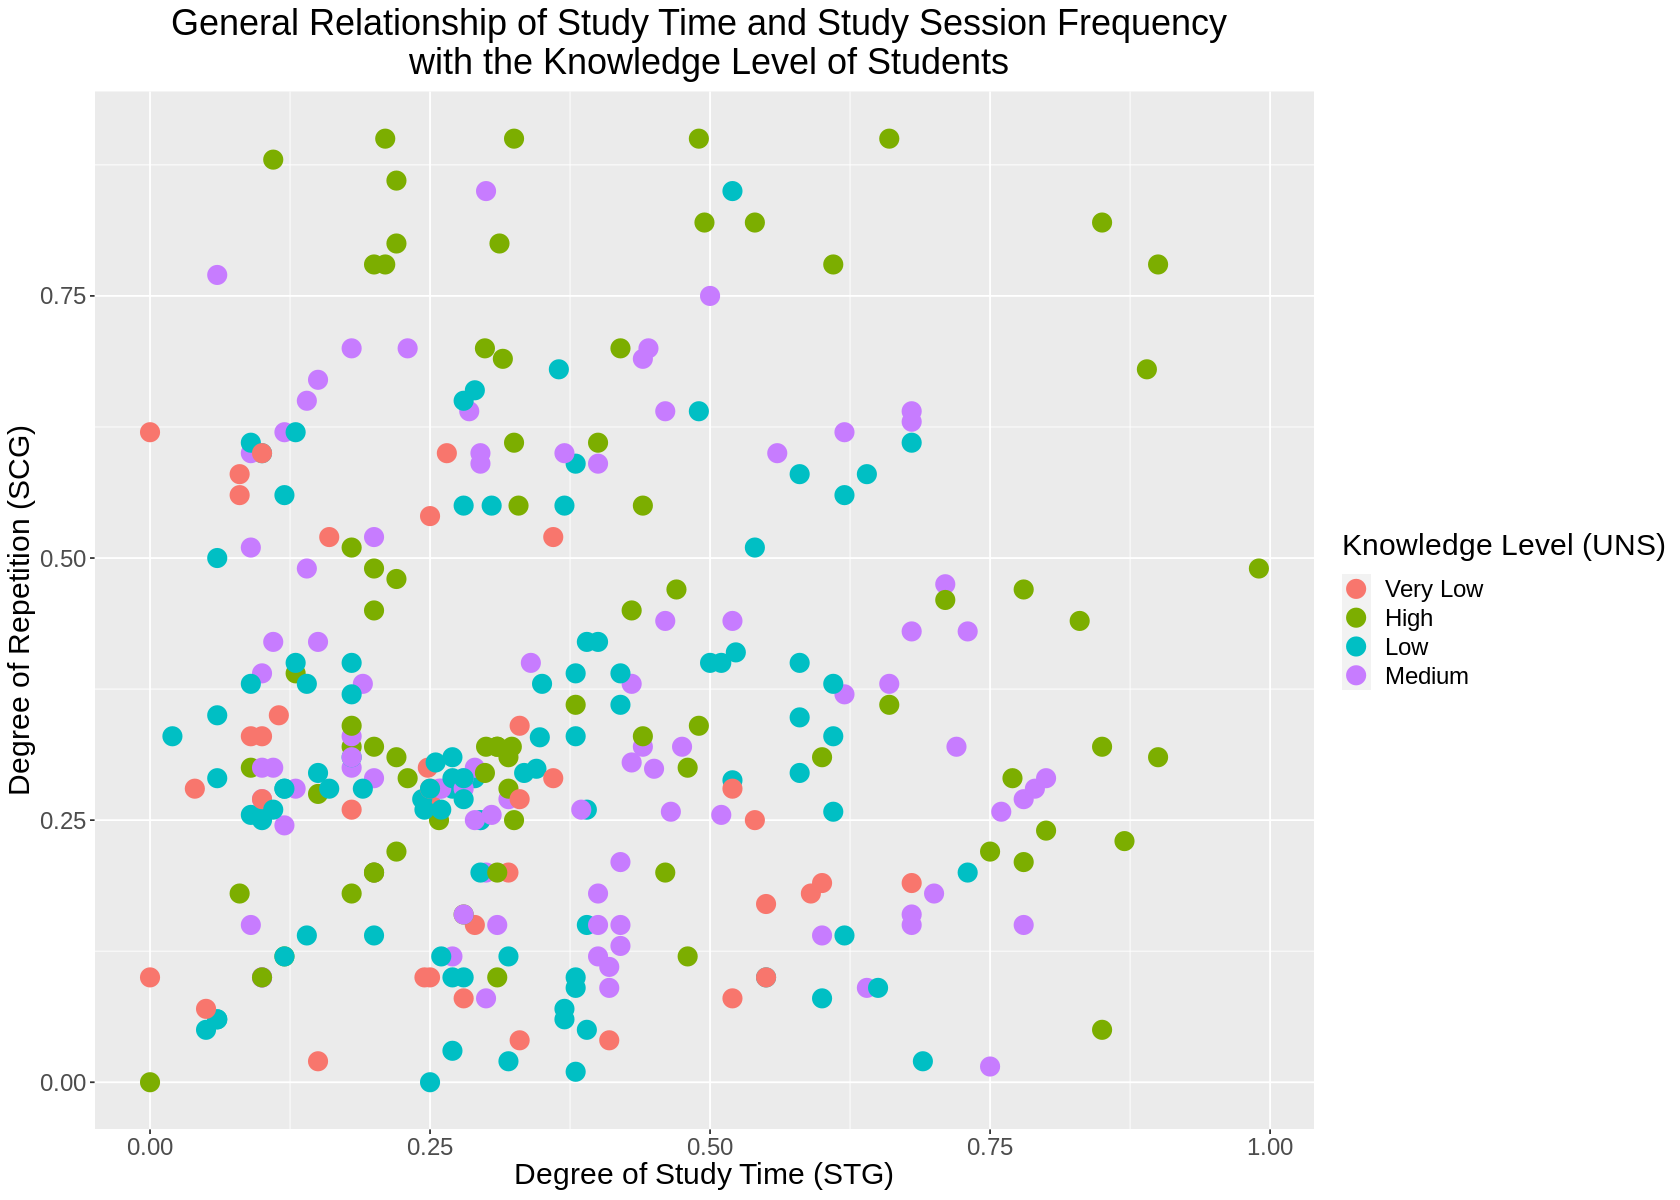

In [299]:
options(repr.plot.width = 14, repr.plot.height = 10)
vis_scatter <- knowledge_training %>% 
    ggplot(aes(x = STG, y = SCG, color = UNS)) +
    geom_point(size = 5) +
    labs(x = "Degree of Study Time (STG)", y = "Degree of Repetition (SCG)", color = "Knowledge Level (UNS)") +
    theme(text = element_text(size = 18), plot.title = element_text(hjust = 0.5)) +
    ggtitle("General Relationship of Study Time and Study Session Frequency \n with the Knowledge Level of Students") +
    scale_color_discrete(labels = c("Very Low", "High", "Low", "Medium"))

vis_scatter

<b>Image 2</b>

Finally, from this graph, it can be observed that higher study times and higher repetitions when studying do lower the possibility of having lower knowledge levels, which means a relationship exists and our research direction is not meaningless. Our exploration is complete, we have confirmed the relevance of our predictor variables, and we can proceed with creating a model to answer our predictive question.

We are trying to predict the knowledge level of a student based on their STG and SCG variables, therefore, we will create a classification knn model to do so.

In [300]:
#First step, find the best value of k to use for knn classification

# Create recipe and model, we do not need to scale this as the imported data is pre-scaled
knowledge_recipe <- recipe(UNS ~ STG + SCG, data = knowledge_training)

knn_tune <- nearest_neighbor(weight_func = "rectangular", neighbors = tune()) %>% 
    set_engine("kknn") %>%
    set_mode("classification")

#perform 5-fold cross-validation 
knowledge_vfold <- vfold_cv(knowledge_training, v = 5, strata = UNS) 

# Sequence of k values to try, we included a reasonable range that wouldn't consume too much computing power
k_vals <- tibble(neighbors = seq(from = 1, to = 50, by = 4))

# Create workflow and fit the model for all values 
knn_results <- workflow() %>%
  add_recipe(knowledge_recipe) %>%
  add_model(knn_tune) %>%
  tune_grid(resamples = knowledge_vfold, grid = k_vals)

# Return data set showing mean accuracy and standard error for each k value
accuracies <- knn_results %>%
  collect_metrics() %>%
  filter(.metric == "accuracy") %>%
  select(neighbors, mean)

accuracies

kmin <- accuracies %>%
    arrange(desc(mean)) %>%
    slice(1) %>%
    select(neighbors) %>%
    pull()
kmin

neighbors,mean
<dbl>,<dbl>
1,0.3814313
5,0.4106833
9,0.3971348
⋮,⋮
41,0.3415120
45,0.3247780
49,0.3412402


[1] 5

<b>Table 4</b>

We will plot these values to gain a visualization of how accurate different values of k are.

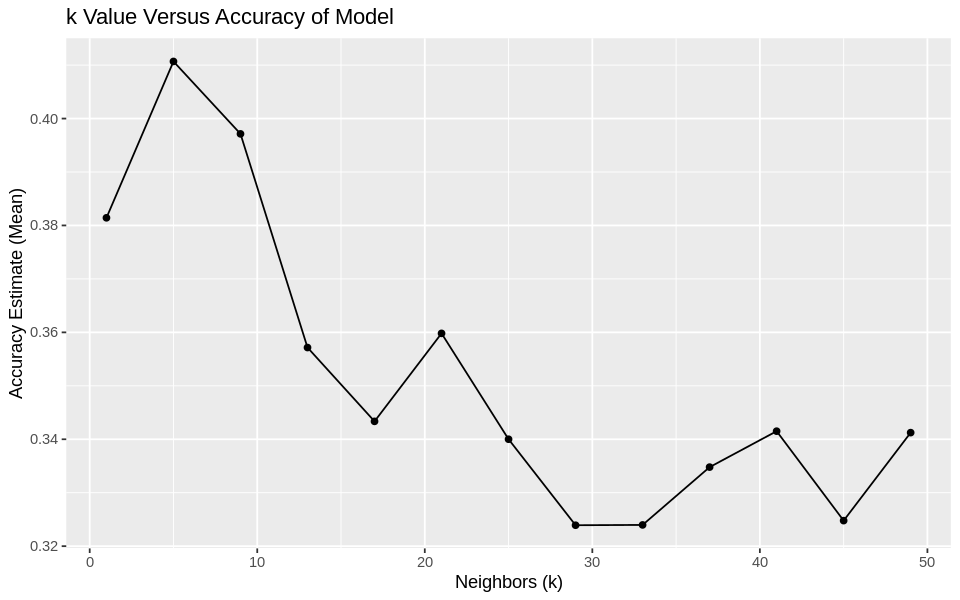

In [301]:
options(repr.plot.width = 8, repr.plot.height = 5)

accuracy_vs_k <- ggplot(accuracies, aes(x = neighbors, y = mean)) +
  geom_point() +
  geom_line() +
  labs(x = "Neighbors (k)", y = "Accuracy Estimate (Mean)", title = "k Value Versus Accuracy of Model")

accuracy_vs_k

<b>Image 3</b>

From the scatterplot, it was observed that the value of k = 5 produced the highest mean accuracy for the model. This choice was deemed reasonable as it was not overly demanding in terms of computing power, and the accuracy of nearby k-values was still relatively high compared to other choices.

As a result, the decision was made to use k = 5 to create the classification model, which will now be created.

In [302]:
# First, creating the classification model
knn_spec <- nearest_neighbor(weight_func = "rectangular", neighbors = 5) %>%
  set_engine("kknn") %>%
  set_mode("classification")

# Using the recipe from the tuning step, knowledge_recipe, as the recipe doesn't change between tuning a k value, and building the model

knowledge_fit <- workflow() %>%
  add_recipe(knowledge_recipe) %>%
  add_model(knn_spec) %>%
  fit(data = knowledge_training)

knowledge_fit



══ Workflow [trained] ══════════════════════════════════════════════════════════
Preprocessor: Recipe
Model: nearest_neighbor()

── Preprocessor ────────────────────────────────────────────────────────────────
0 Recipe Steps

── Model ───────────────────────────────────────────────────────────────────────

Call:
kknn::train.kknn(formula = ..y ~ ., data = data, ks = ~5, kernel = ~"rectangular")

Type of response variable: nominal
Minimal misclassification: 0.5723684
Best kernel: rectangular
Best k: 5

<b>Table 5</b>

With our model complete, we can now begin answering our predictive question.

We will use our model to predict the test data while keeping it blind from the actual UNS of each observation, then we will compare these results with the actual UNS data in that data frame, and evaluate how accurate our model was at predicting knowledge levels. And subsequently answering our predictive question about how effectively study time, and study session distribution, can be used to predict a student's knowledge level.

In [303]:
prediction_results <- predict(knowledge_fit, knowledge_testing) %>%
    bind_cols(knowledge_testing)

result_metrics <- prediction_results %>%
    metrics(truth = UNS, estimate = .pred_class) %>%
    filter(.metric == "accuracy")

result_metrics



.metric,.estimator,.estimate
<chr>,<chr>,<dbl>
accuracy,multiclass,0.5555556


<b>Table 6</b>

So ultimately, our model was able to predict the UNS level of students with roughly 56% accuracy for the testing set.

To visually observe what our model got correct and got wrong, we can create a scatter with color coded points indicating if it was guessed correctly. 

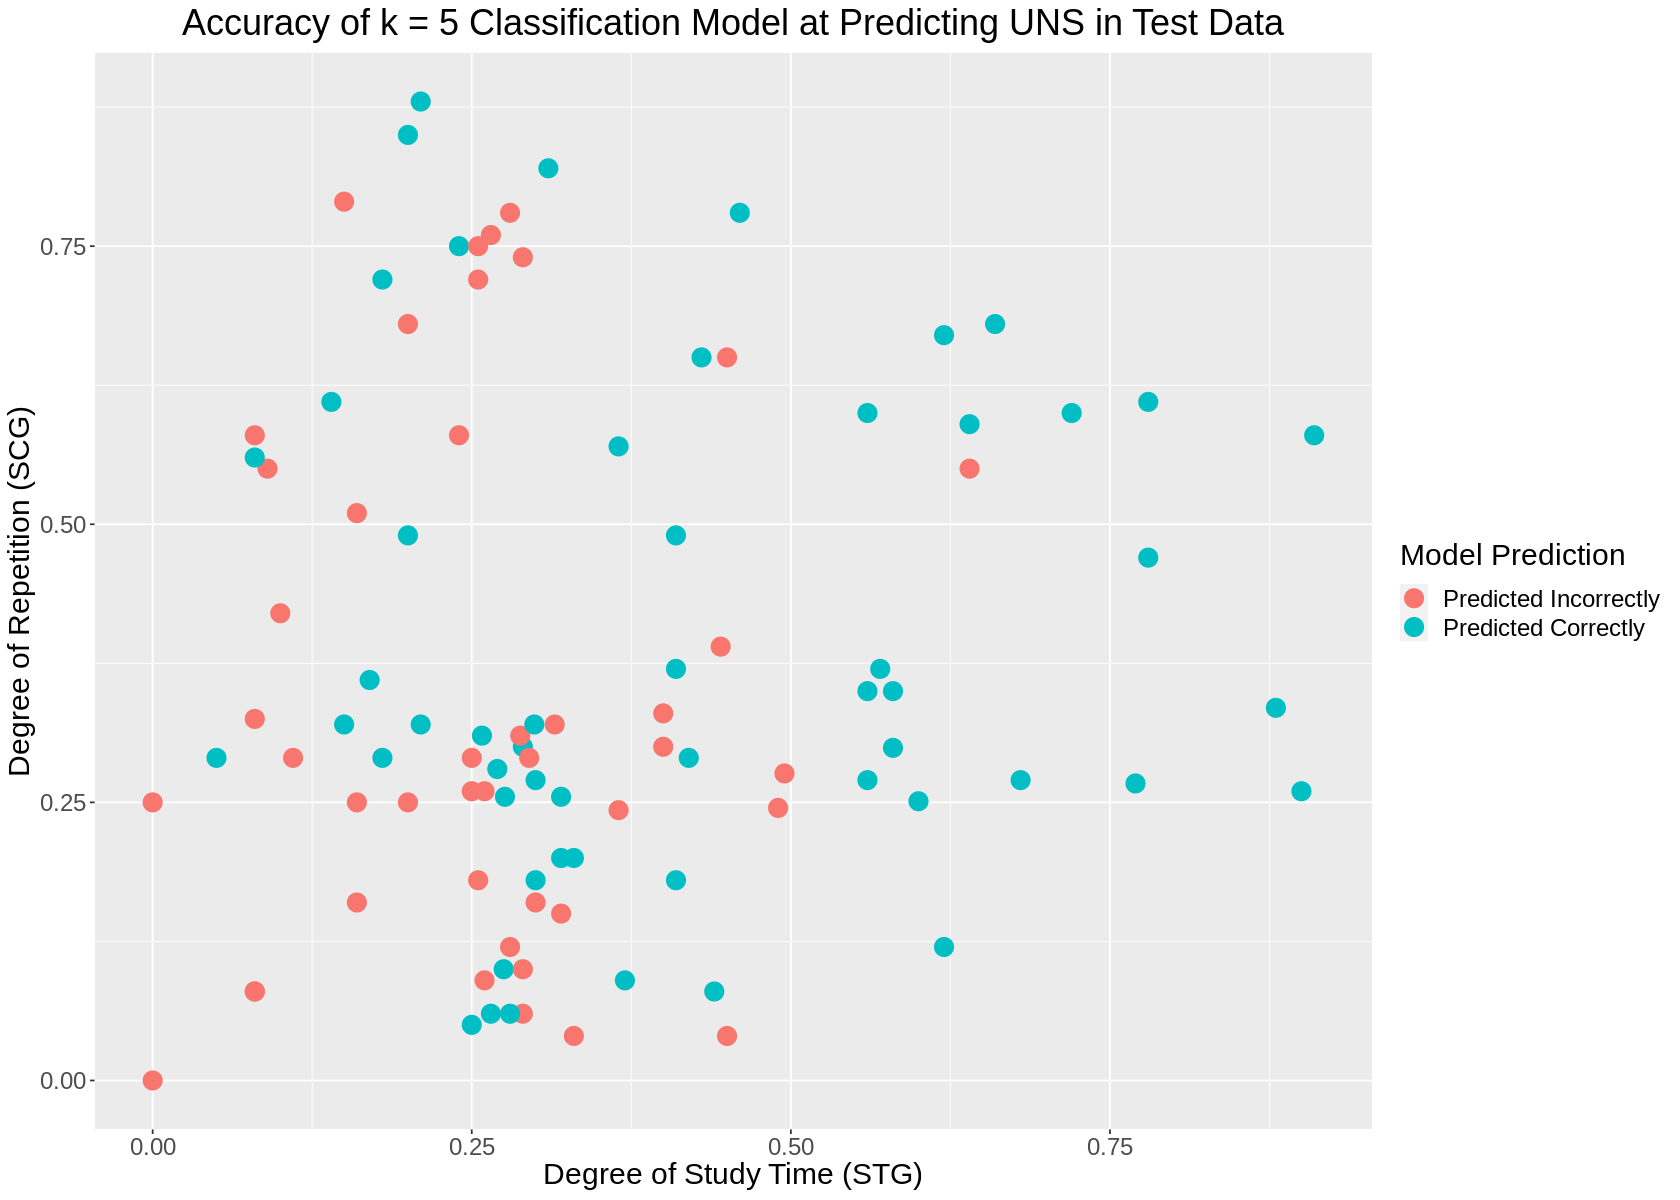

In [304]:
prediction_results <- prediction_results %>%
    mutate(correct = (as.character(.pred_class) == as.character(UNS)))

options(repr.plot.width = 14, repr.plot.height = 10)
prediction_accuracy_plot <- prediction_results %>%
    ggplot(aes(x = STG, y = SCG, color = correct)) +
    geom_point(size = 5) +
    scale_color_discrete(labels = c("Predicted Incorrectly", "Predicted Correctly")) +
    labs(x = "Degree of Study Time (STG)", y = "Degree of Repetition (SCG)", color = "Model Prediction") +
    theme(text = element_text(size = 18), plot.title = element_text(hjust = 0.5)) +
    ggtitle("Accuracy of k = 5 Classification Model at Predicting UNS in Test Data")
    
prediction_accuracy_plot


<b>Image 4</b>

## Discussion

From the results of the model, as shown in image 4, it can be observed that the model is highly accurate for higher values of STG, and relatively accurate in the regions of low SCG and mid-range STG values. However, there is a large number of incorrect predictions at low STG values. While the final accuracy of 56% may not seem impressive, it can still be useful in predicting specific values of STG and SCG. For instance, all predictions were correct except for one after the STG value reached 0.50.

### High SCG, Low STG

Using image 2 as a reference, it can be seen that our model was only moderately effective at predicting values in this range. The fact that “very low” UNS values are super rare here agrees with current research into determining factors of student success, which states that consistent, distributed practice imprints knowledge into the mind by forcing the student to repeatedly learn and recall their memories of the information (Sean, K.).

However, it is clear from our findings that the model struggles to predict values here, which means that although distributed study sessions are likely to help the student retain a bare minimum of information, if they don’t put in enough raw time (low STG), then the consistency of their knowledge retention is still quite poor. We can therefore state that although studying efficiently and wisely using time is powerful, it is still ultimately the number of hours that a person puts in that provides consistent results.


### Low STG and Low SCG

Our model was roughly a coin flip in predicting values at this range. Looking from image 2, this area is filled with non-negligible quantities of all four knowledge levels, seemingly without a trend. This makes sense, as if an individual studied very few sessions, and had very low total study time, then that implies a complete lack of effort in studying for the course. Therefore their knowledge level of the subject will depend almost entirely on other factors such as previous knowledge of the subject, performance in related courses, and natural talent in a subject. The data when modeled with only SCG and STG intuitively is expected to be chaotic, and the low accuracy in this region makes sense.

### High STG

Surprisingly, our model was very accurate at predicting knowledge levels in this range. From image 2, it can be observed that on average, knowledge levels here were all very high, consisting of exclusively "medium" and "high" knowledge values. This means that studying a lot will guarantee a decent amount of knowledge retained, we wanted to investigate if other research agreed with this.

After consulting some previous research in this area, it was found that the current consensus is that more studying by itself is not a linear indicator of success. Stych, A. found that allowing the brain to rest through leisure activities and other breaks while learning leads to greater focus and learning abilities.

It was also discovered in a Stanford study that students who self-reflected, strategized, and continuously tweaked their personal study tactics were able to significantly outperform their peers who studied roughly equal amounts of time (Martinovich, M.).

Combined with our results, this implies that at higher hours of studying, although it does not immediately guarantee the highest level of success, a student’s performance will become more stable, as referenced by the model’s very accurate ability to differentiate between the medium and high levels in this region, with the only other predictor being SCG. This means the effectiveness of smarter studying strategies is greatly amplified by greater study times.


## Conclusion

Overall, our assumption that higher values of SCG (Spaced Repetition) and STG (Study Time) would result in higher levels of knowledge was correct. However, we discovered unexpected findings. The model was much more accurate at high STG values rather than at high SCG values. This was surprising, as one might expect that distributed studying would result in greater consistency compared to spending more time studying. However, the opposite was true.

Ultimately, our primary discovery was that for STG values greater than 0.5, the model's predictions and accuracy were much more accurate and students generally performed better, as shown in Image 2. This finding is important in discouraging students from seeking shortcuts to learning. Previous research has shown that there are strategies for more efficient learning, but a sufficient baseline of study time is necessary to achieve consistent results. In other words, the number of hours spent studying matters.

The inaccuracies of the model are largely due to the clustering of points with vastly different UNS (unknown) values when using STG and SCG as the only predictors. Our k-value was optimized, and the choice was apparent upon visual inspection, meaning that overfitting and underfitting did not significantly affect our results. There may have been some overfitting with a low k value of 5, but the main reason for the low prediction accuracy is due to the clustering of points with various UNS values.


A clear area for future investigation is therefore researching what happens at higher SCG values using other/more predictor variables. Since SCG and STG alone are not sufficient to accurately predict UNS values at this range, research involving more predictor variables is required to learn more, potential candidates are PEG (exam performance on the learned material), and LPR (exam performance on material related to target/goal subject). This research could benefit students who are strained by time from external responsibilities and require the knowledge of how to make the most out of limited study time.


## Sources

*Hamdi Tolga Kahraman, Sagiroglu, S., Colak, I., Developing intuitive knowledge classifier and modeling of users' domain dependent data in web, Knowledge Based Systems, vol. 37, pp. 283-295, 2013.*

*Martinovich, M. (2017, May 5). Studying more strategically equals improved exam scores. Stanford News. Retrieved April 9, 2022, from https://news.stanford.edu/2017/05/08/studying-strategically-equals-improved-exam-scores/*

*Stych, A. (2018, May 8). Why more studying doesn't mean more learning. Bizjournals.com. Retrieved April 9, 2022, from https://www.bizjournals.com/bizwomen/news/latest-news/2018/05/hy-more-studying-doesnt-mean-more-learning.html?page=all*

*Sean, K. (2019, May 9). Ask the cognitive scientist: Distributed practice. Digital Promise. Retrieved April 7, 2022, from https://digitalpromise.org/2019/05/08/ask-the-cognitive-scientist-distributed-practice/*